In [1]:
import sys; print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend(['/home/tm/projects/Open_Close_GNN-1/'])

Python 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0] on linux


In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from seaborn import heatmap
from sklearn.model_selection import GroupKFold
from torch.optim import lr_scheduler
from torch.utils.data import SubsetRandomSampler
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm

from model.dataset import OpenCloseDataset
from model.gnn_model import GCN, GATv2
from model.utils import device, eval_epoch, train, train_epoch, load_data_and_groups

import pickle

In [3]:
np.random.seed(42)

In [9]:
# helper loading function
closed, opened, groups, labels = load_data_and_groups(
    pickle_path=r'C:\Users\user\YandexDisk\IHB\Projects\OpenCloseFMRI\data\FC_matrix\FC_IHB.pickle',
    filename='HCPex_aCompCor10_24P')

In [3]:
opened_ihb = np.load('/home/tm/opened6.npy')
closed_ihb = np.load('/home/tm/closed6.npy')

In [19]:
opened = np.load('/home/tm/opened_china6.npy')
closed = np.load('/home/tm/closed_china6.npy')

In [5]:
import torch
from torch_geometric.data import Dataset, Data
from torch_geometric.utils import dense_to_sparse, to_dense_adj
from scipy.sparse import coo_matrix
import numpy as np
import os
import shutil
from scipy.io import loadmat

from torch_geometric.nn import knn_graph


class OpenCloseDataset(Dataset):
    def __init__(self, datafolder, open_file, close_file, 
                 reload=False, test=False, transform=None, 
                 pre_transform=None, k_degree=10, edge_attr=None):

        self.reload = reload
        self.test = test
        self.datafolder = datafolder
        self.close = close_file
        self.open  = open_file
        self.edge_attr = edge_attr
        self.k_degree = k_degree
        

        if self.reload:
            for root, dirs, files in os.walk(f'{self.datafolder}/processed'):
                for f in files:
                    os.unlink(os.path.join(root, f))
                for d in dirs:
                    shutil.rmtree(os.path.join(root, d))

        super().__init__(root=datafolder, transform=transform, pre_transform=pre_transform)

    @property
    def raw_file_names(self):
        return ['open_84.npy', 'close_84.npy']
    
    @property
    def processed_file_names(self):
        return [f'data_{i}.pt' for i in range(len(self.close) + len(self.open))]
        
    def len(self):
        return len(self.close) + len(self.open)
    
    
    def process(self):

        for index in range(len(self.open)):
            _ = self._load_and_save(self.open[index], index, 'open')

        for index in range(len(self.close)):
            _ = self._load_and_save(self.close[index], index, 'close')


    def _load_and_save(self, matr, index, state):

        x = torch.from_numpy(matr).float()

        #adj = self.compute_KNN_graph(matr, k_degree=self.k_degree)
        
        #adj = torch.from_numpy(adj).float()
        #edge_index, edge_attr = dense_to_sparse(adj)
        #self.edge_attr = edge_attr
        edge_index = knn_graph(x, self.k_degree)


        label = torch.tensor(0 if state == 'close' else 1).long()
        data = Data(x=x, edge_index=edge_index, edge_attr=self.edge_attr, y=label)

        index = index + len(self.open) if state == 'close' else index


        torch.save(data,
                    os.path.join(self.processed_dir,
                                f'data_{index}.pt'))
        
        return data
    
    def compute_KNN_graph(self, matrix, k_degree):
        """ Calculate the adjacency matrix from the connectivity matrix.
            Adapted from: https://github.com/QKmeans0902/GCN_MDD_Classification
        """

        matrix = np.abs(matrix)
        idx = np.argsort(-matrix)[:, 0:k_degree]
        matrix.sort()
        matrix = matrix[:, ::-1]
        matrix = matrix[:, 0:k_degree]

        A = self._adjacency(matrix, idx).astype(np.float32)

        return A

    def _adjacency(self, dist, idx):

        m, k = dist.shape
        assert m, k == idx.shape
        assert dist.min() >= 0

        # Weight matrix.
        I = np.arange(0, m).repeat(k)
        J = idx.reshape(m * k)
        V = dist.reshape(m * k)
        W = coo_matrix((V, (I, J)), shape=(m, m))

        # No self-connections.
        W.setdiag(0)

        # Non-directed graph.
        bigger = W.T > W
        W = W - W.multiply(bigger) + W.T.multiply(bigger)

        return W.todense()


    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, 'test_'
                                           f'data_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir,
                                           f'data_{idx}.pt'))
        return data



In [20]:
full_dataset = OpenCloseDataset(datafolder='../data/', # dir where the processed files will be stored
                                open_file=opened, # data should be np.array of size (n_subjects, n_rois, n_rois)
                                close_file=closed, # an array for closed and opened eyes
                                reload=True, # whether you want to reload already processed graphs
                                k_degree=3) # k degree

Processing...
Done!


Since we have two scans for one person, to avoid data leak we define groups, where each subject represents one group. Then use these indeces to create train and validation sets.

In [21]:
labels = [full_dataset[i].y for i in range(len(full_dataset))]
groups = np.concatenate([
            np.arange(opened.shape[0], dtype=int), 
            np.arange(closed.shape[0], dtype=int)
            ])

In [22]:
gkf = GroupKFold()
for i, (train_index, val_test_index) in enumerate(gkf.split(labels, groups=groups)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}, groups={groups[train_index]}")
    print(f"  Test:  index={val_test_index}, group={groups[val_test_index]}")
    break

Fold 0:
  Train: index=[  0   1   2   3   4   6   8   9  11  12  13  14  15  16  17  18  19  20
  21  23  24  25  26  28  29  30  31  33  35  37  38  39  41  42  43  44
  46  47  48  49  50  51  52  54  56  57  59  60  61  62  63  64  65  66
  67  68  69  71  72  73  74  76  77  78  79  81  83  85  86  87  89  90
  91  92  94  95  96  97  98  99 101 102 103 104 105 107 108 109 110 111
 112 114 115 116 117 119], groups=[ 0  1  2  3  4  6  8  9 11 12 13 14 15 16 17 18 19 20 21 23 24 25 26 28
 29 30 31 33 35 37 38 39 41 42 43 44 46 47  0  1  2  3  4  6  8  9 11 12
 13 14 15 16 17 18 19 20 21 23 24 25 26 28 29 30 31 33 35 37 38 39 41 42
 43 44 46 47 48 49 50 51 53 54 55 56 57 59 60 61 62 63 64 66 67 68 69 71]
  Test:  index=[  5   7  10  22  27  32  34  36  40  45  53  55  58  70  75  80  82  84
  88  93 100 106 113 118 120], group=[ 5  7 10 22 27 32 34 36 40 45  5  7 10 22 27 32 34 36 40 45 52 58 65 70
 72]


In [23]:
train_loader = DataLoader(full_dataset, batch_size=32, shuffle=False, sampler=SubsetRandomSampler(train_index))
val_loader = DataLoader(full_dataset, batch_size=32, shuffle=False, sampler=SubsetRandomSampler(val_test_index))

## GCN

In [90]:
torch.cuda.empty_cache()

In [24]:
model = GCN(full_dataset.num_features, channels=[96, 32], dropout=0.2).to(device())
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()
epochs = 150
scheduler = lr_scheduler.StepLR(optimizer, step_size=epochs//5, gamma=0.1, last_epoch=-1)
sum(p.numel() for p in model.parameters())

14594

In [25]:
history = train(model, epochs, train_loader, val_loader, loss, optimizer, 
                scheduler=scheduler, save_best=True, path_to_save='..whatever.pt')

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 001, Train Loss: 0.6863, Test Loss 0.6816, Train Acc: 0.5938, Test Acc: 0.5600
Test precision: 0.4706, Test recall: 0.8000, Test F1: 0.5926
Epoch: 002, Train Loss: 0.6693, Test Loss 0.6664, Train Acc: 0.6979, Test Acc: 0.5600
Test precision: 0.4286, Test recall: 0.3000, Test F1: 0.3529
Epoch: 003, Train Loss: 0.6556, Test Loss 0.6560, Train Acc: 0.7396, Test Acc: 0.6400
Test precision: 0.6000, Test recall: 0.3000, Test F1: 0.4000
Epoch: 004, Train Loss: 0.6399, Test Loss 0.6456, Train Acc: 0.7812, Test Acc: 0.6400
Test precision: 0.6000, Test recall: 0.3000, Test F1: 0.4000
Epoch: 005, Train Loss: 0.6238, Test Loss 0.6360, Train Acc: 0.7812, Test Acc: 0.6400
Test precision: 0.6000, Test recall: 0.3000, Test F1: 0.4000
Epoch: 006, Train Loss: 0.6027, Test Loss 0.6244, Train Acc: 0.8021, Test Acc: 0.6400
Test precision: 0.6000, Test recall: 0.3000, Test F1: 0.4000
Epoch: 007, Train Loss: 0.5772, Test Loss 0.6116, Train Acc: 0.8229, Test Acc: 0.6800
Test precision: 0.7500, Test rec

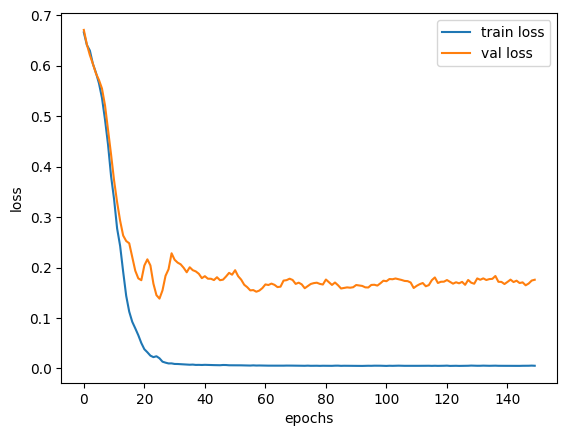

In [12]:
train_loss, val_loss, train_acc, test_acc = zip(*history)
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend();

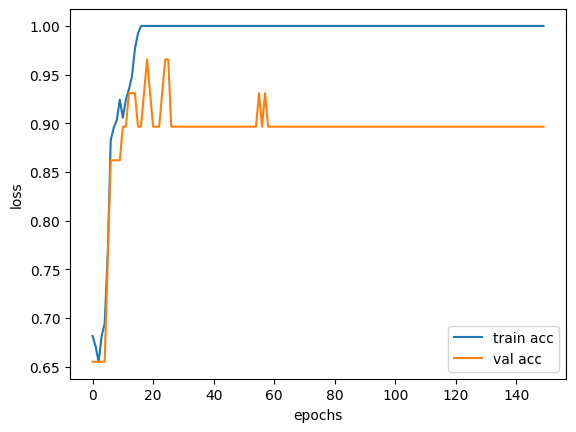

In [13]:
plt.plot(train_acc, label='train acc')
plt.plot(test_acc, label='val acc')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend();

In [26]:
eval_epoch(val_loader, model, loss)

(0.5154416561126709, 0.8, 0.85714287, 0.6, 0.7058824)

In [27]:
closed_test = np.load('/home/tm/closed_china6_test.npy')

In [32]:
test_data = OpenCloseDataset(datafolder='../data_test/', # dir where the processed files will be stored
                                open_file=[], # data should be np.array of size (n_subjects, n_rois, n_rois)
                                close_file=closed_test, # an array for closed and opened eyes
                                reload=True, # whether you want to reload already processed graphs
                                k_degree=3) # k degree

Processing...
Done!


In [33]:

[test_data[i].y for i in range(len(test_data))]

[tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0)]

In [34]:
test_dataset = DataLoader(test_data, batch_size=32, shuffle=False)
eval_epoch(test_dataset, model, loss)

(0.30167514085769653, 0.8695652, 0.0, 0.0, 0.0)

test on ihb data

In [15]:
test_dataset = OpenCloseDataset(datafolder='../data_test/', # dir where the processed files will be stored
                                open_file=opened_ihb, # data should be np.array of size (n_subjects, n_rois, n_rois)
                                close_file=closed_ihb, # an array for closed and opened eyes
                                reload=True, # whether you want to reload already processed graphs
                                k_degree=3) # k degree

Processing...
Done!


In [16]:
test_dataset = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [17]:
test_history = eval_epoch(test_dataset, model, loss)
# np.mean(losses), np.mean(acc), np.mean(pr), np.mean(rc), np.mean(f)

In [18]:
test_history

(1.6463405212077002, 0.5989583, 0.5, 0.06979167, 0.121164024)

# Group kFold

In [ ]:
# GCN
channels = [32, 8]
n_epochs = 30
lr = 0.001
skf = GroupKFold(n_splits=10)
eval_metrics = np.zeros((skf.n_splits, 4))
crossval_dataset = full_dataset #+ val_dataset

labels = [crossval_dataset[i].y for i in range(len(crossval_dataset))]


for n_fold, (train_idx, test_idx) in tqdm(enumerate(skf.split(labels, groups=groups))):
    torch.cuda.empty_cache()
    model = GCN(crossval_dataset.num_features, channels=channels, dropout=0.3).to(device())
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    scheduler = lr_scheduler.StepLR(optimizer, step_size=30//3, gamma=0.1, last_epoch=-1, verbose=False)

    train_loader_ = DataLoader(crossval_dataset[list(train_idx)], batch_size=16, shuffle=True)
    test_loader_ = DataLoader(crossval_dataset[list(test_idx)], batch_size=16, shuffle=True)
    min_v_loss = np.inf
    print(n_fold)
    pr, rc, acc = [], [], []
    for epoch in range(n_epochs):
        train_epoch(train_loader_, model, criterion, optimizer)
        train_loss, train_acc, _, _, train_f1 = eval_epoch(train_loader_, model, criterion)
        val_loss, test_acc, _, _, test_f1 = eval_epoch(test_loader_, model, criterion)
        scheduler.step()
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss {val_loss:.4f},',
              f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Test F1: {test_f1:.4f}')

        pr.append(test_f1)
        acc.append(test_acc)
        if min_v_loss > val_loss:
            min_v_loss = val_loss
            best_test_acc = test_acc

    eval_metrics[n_fold, 0] = best_test_acc
    eval_metrics[n_fold, 1] = np.mean(acc)
    eval_metrics[n_fold, 2] = np.std(acc)
    eval_metrics[n_fold, 3] = np.mean(pr)

In [32]:
print(np.mean(eval_metrics[:, 0])) # 0.7614)
print(np.std(eval_metrics[:, 0]))
print(np.mean(eval_metrics[:, 3]))


0.765625
0.08529590039972614
0.6974999129772186


In [83]:
np.mean(eval_metrics[:, 2])

0.07113302685320377

In [85]:
np.mean(eval_metrics[:, 1])

0.6536309540271759

# Explanation

In [26]:
from collections import defaultdict
from model.explain import explain, aggregate_edge_directions, to_symmetrical, model_forward



In [29]:
close_salient = salient_edges(full_dataset, model, label=0)

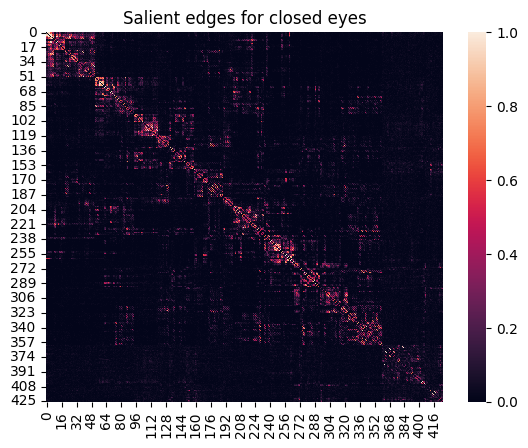

In [32]:
from seaborn import heatmap

heatmap(close_salient)
plt.title('Salient edges for closed eyes');